In [1]:
%load_ext autoreload
%autoreload 2

import itertools
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
from tqdm import tqdm
from scipy import stats
import yaml

from graph_generation import create_ER, dataset_nclass_ER, dataset_regression_ER
from models import GCN
from train import Trainer, Dataset
from embedding import Embedding
from experiments import experiment_embedding
from config_valid import Config

import torch
from torch_geometric.loader import DataLoader
import tensorflow as tf

from deepdiff import DeepDiff

In [2]:
#config = yaml.safe_load(open("configs.yml"))
config_c = Config("configs.yml")
config_c.load_conf()
config_c.valid_conf()

In [3]:
if config_c.conf['graph_dataset']['continuous_p']:
    dataset_grafi_nx, dataset_labels = dataset_regression_ER(config_c)
else:
    dataset_grafi_nx, dataset_labels, list_p = dataset_nclass_ER(config_c)  # impostare ultimo neuron layer > 1 anche se cambia poi con la grid search

Mean connectivity for each node: 12.999 p=0.05
Mean connectivity for each node: 77.458 p=0.3


In [4]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]

layers1 = [[1, 8, i] for i in range(2, 9, 6)]
layers1_2 = [[1, 16, i] for i in range(2, 17, 2)]

layers1_3 = [[1, 32, i] for i in range(2, 33, 2)]
layers2 = [[1, i, i, 1] for i in range(2, 100, 12)]
layers = layers1 + layers2

num_nodes = [260, 280, 300, 320, 340, 360]

epochs = [0, 1, 3, 10, 50, 5000]

In [5]:
#trials = layers1# + layers1_2 + layers1_3
trials = [[1,16,1]]

In [6]:
import copy
def make_config(config, trials):
    configs = []
    #for lr, layer, num_nodes in trials:
    for layer in trials:
        #config['training']['learning_rate'] = lr
        
        config['model']['neurons_per_layer'] = layer
        #config['training']['epochs'] = epoch
        #config['graph_dataset']['Num_nodes'] = num_nodes
        confclass = Config.fromdict(copy.deepcopy(config))
        confclass.valid_conf()
        configs.append(confclass)
    return configs

In [7]:
configs2 = make_config(config_c.conf, trials)

In [8]:
# carica il master config
with open('configs_21-6-22.pickle', 'rb') as handle:
    configs = pickle.load(handle)

# check su run già fatti
actual_runs = []
for i, c2 in enumerate(configs2):
    cambi = True
    for j, c in enumerate(configs):
        ddiff = DeepDiff(c, c2.conf, ignore_order=False)
        cambi = ddiff.get('values_changed')
        if not cambi:
            print(f'salto i:{i} j:{j}')
            break    
    if cambi:
        actual_runs.append(c2)
        
print(len(actual_runs), len(configs2))

1 1


In [9]:
#regression: list_p = None, continuous_p True
# classificatrion: list_p, continuous_p = False

for i, c in enumerate(actual_runs):
    print(f'Run {i}/{len(actual_runs)}')
    for j in range(1):
        embeddings, trainer, test_loss_list = experiment_embedding(c, dataset_grafi_nx, dataset_labels, list_p, False)
        #corrs, error = embeddings.calc_correlation()
        #c['correlations'] = corrs
        #c['error'] = error 
        c.conf['test_loss'] = test_loss_list
        c.conf['distance_of_means'] = embeddings.distance_of_means   # TODO: sarebbe il caso di mettere una gerarchia di chiavi anche per i risultati
        #c[f'run_num'] = j

Run 0/1
GCN(
  (convs): ModuleList(
    (0): GCNConv(1, 16)
  )
  (pools): ModuleList()
  (lin): Linear(in_features=16, out_features=1, bias=True)
  (leaky): LeakyReLU(negative_slope=0.03)
)
BCEWithLogitsLoss()
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.49it/s]


Tempo impiegato: 3.4509055614471436
tensor([1.], device='cuda:0') 42
tensor([0.], device='cuda:0') 18
runs/lr-0.01_epochs2500_bs100_neurons-1-16-1_24Jun_09-53-36
Run training for 2500 epochs
Before training Test loss: 0.03938756717575921
Epoch: 0	Test loss: 0.03919632236162821
Epoch: 100	Test loss: 0.038516120778189764
Epoch: 200	Test loss: 0.03850396474202474
Epoch: 300	Test loss: 0.03845722476641337
Epoch: 400	Test loss: 0.03838726878166199
Epoch: 500	Test loss: 0.03827931152449714
Epoch: 600	Test loss: 0.03800071941481696
Epoch: 700	Test loss: 0.03770324256685045
Epoch: 800	Test loss: 0.03733851181136237
Epoch: 900	Test loss: 0.036567982700135976
Epoch: 1000	Test loss: 0.03620003660519918
Epoch: 1100	Test loss: 0.03514555427763197
Epoch: 1200	Test loss: 0.03415432572364807
Epoch: 1300	Test loss: 0.03357488248083326
Epoch: 1400	Test loss: 0.03130499521891276
Epoch: 1500	Test loss: 0.02949627571635776
Epoch: 1600	Test loss: 0.02759811282157898
Epoch: 1700	Test loss: 0.0253308994902504

In [ ]:
whole_data = trainer.dataset.dataset_pyg
all_data_loader = DataLoader(whole_data, batch_size=trainer.dataset.bs, shuffle=False)
embeddings_array = trainer.take_embedding(all_data_loader)

0.0102240965

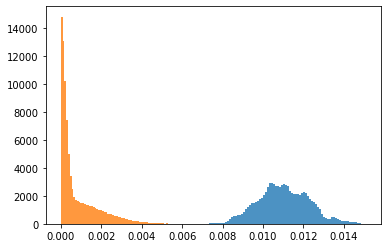

In [10]:
#plt.plot(embeddings.embeddings_array);
plt.hist(embeddings.inter_dists, bins=80, alpha=0.8)
plt.hist(embeddings.intra_dists, bins=80, alpha=0.8)
    
mean_intra = np.mean(embeddings.intra_dists)
mean_inter = np.mean(embeddings.inter_dists)
distance_of_means = mean_inter - mean_intra
distance_of_means

# Save

In [14]:
dati = actual_runs

In [15]:
def config2df(dati):
    df_data = pd.DataFrame(columns=['range_p', 'Num_nodes', 'Num_grafi_totali', 'learning_rate', 'batch_size', 'neurons_per_layer', 'correlations', 'error', 'test_loss', 'distance_of_means', 'batch_norm'])
    df_data['range_p'] = [d['graph_dataset']['range_p'] for d in dati]
    df_data['Num_nodes'] = [d['graph_dataset']['Num_nodes'] for d in dati]
    df_data['Num_grafi_totali'] = [d['graph_dataset']['Num_grafi_totali'] for d in dati]
    df_data['learning_rate'] = [d['training']['learning_rate'] for d in dati]
    df_data['batch_size'] = [d['training']['batch_size'] for d in dati]
    df_data['neurons_per_layer'] = [d['model']['neurons_per_layer'] for d in dati]
    df_data['correlations'] = [d.get('correlations') for d in dati]
    df_data['error'] = [d.get('error') for d in dati]
    df_data['test_loss'] = [[round(l, 10) for l in d.get('test_loss') or []] for d in dati ]  # or [] : per il caso in cui d.get restituisca None
    df_data['distance_of_means'] = [d.get('distance_of_means') for d in dati]  # caso della classification
    #df_data['run_num'] = [d.get('run_num') for d in dati]
    df_data['batch_norm'] = [d['model']['put_batchnorm'] for d in dati]
    df_data['num_epochs'] = [d['training']['epochs'] for d in dati]
    return df_data

In [15]:
# correggo il dataframe esistente aggiungendo i campi che mi viene in mente di aggiungere nel tempo
file = "df_configs_class.csv" #"df_configs.csv" #
df_data = pd.read_csv(file)  
df_data['num_epochs'] = 5000
df_data.to_csv(file) 

In [16]:
df_data = config2df(dati)

In [17]:
df_data

,range_p,Num_nodes,Num_grafi_totali,learning_rate,batch_size,neurons_per_layer,correlations,error,test_loss,distance_of_means,batch_norm,num_epochs
0,"[0.05, 0.6]",260,1000,0.01,100,"[1, 32]",None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.010872,True,250


In [46]:
import os
outfile = "df_configs_class.csv" #"df_configs.csv" #
df_data.to_csv(outfile, index=False, mode='a', header=not os.path.exists(outfile))

In [30]:
# aggiungo al master config
configs.extend(actual_runs)

In [33]:
for c in configs:
    if c.get('test_loss'):
        del c['test_loss']

In [34]:
with open('configs_21-6-22.pickle', 'wb') as handle:
    pickle.dump(configs, handle, protocol=pickle.HIGHEST_PROTOCOL)